In [1]:
#doing things with data
import pandas as pd
import itertools
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

#import r2
from sklearn.metrics import r2_score

import env
import acquire as a
import wrangle as w
import explore as e
import prepare as p
import evaluate as eva

import warnings
warnings.filterwarnings("ignore")

# Acquire
- Performed initial exploratory analysis to ensure required colums were brought in from SQL
- Wrote necessary function to pull data from SQL using embedded ENV/Acquire.py files (repeatable)
- There is a CSV now with the requisite rows, for quicker future access

In [2]:
# get data
df = a.get_zillow2()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,NaN,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,NaN,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,NaN,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,NaN,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,NaN,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,NaN,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,NaN,96370.0,12447.0


In [3]:
#take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tax_Value   52440 non-null  float64
 1   Sqft        52359 non-null  float64
 2   County      52441 non-null  float64
 3   Bedrooms    52441 non-null  float64
 4   Bathrooms   52441 non-null  float64
 5   Lot_Size    52072 non-null  float64
 6   Year_Built  52325 non-null  float64
 7   Pool        11096 non-null  float64
 8   Zip_Code    52415 non-null  float64
 9   City        51404 non-null  float64
dtypes: float64(10)
memory usage: 4.4 MB


# Prepare
- Checked for nulls
    - Set Pool value nulls to 0 (for no pool). The data matches the average of homes in Southern California with pools.  
    - Drop nulls, there are only 568 null values which is .01% of the data. 
    - Dropping them will not have a major impact on the result of the study.
- Encode values for machine learning
- Handle outliers
    - Tax_Value less than 2 million
    - Sqft less than 7250 
    - Bedrooms less than 8
    - Bathrooms less than 5
- Create dummy variable for County location
- Create Wrangle file
- Create Train, Validate, and Test (60%, 20%, 20% : respectively)
- Create scaled data set (to use in modeling phase)

In [4]:
#Check for nulls/missing values
df.isnull().sum()

Tax_Value         1
Sqft             82
County            0
Bedrooms          0
Bathrooms         0
Lot_Size        369
Year_Built      116
Pool          41345
Zip_Code         26
City           1037
dtype: int64

In [5]:
#look at pool values
df.Pool.value_counts()

1.0    11096
Name: Pool, dtype: int64

In [6]:
# The national average is 8% of homes have pools and southern California is 19%. I will fill na with 0 as (no pool)
11096/52411

0.21171128198278988

In [7]:
# fill in null pool values with 0 to identify those houses not having a pool
df.Pool = df.Pool.fillna(0)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [8]:
# verify pool changes have been made
df.isnull().sum()

Tax_Value        1
Sqft            82
County           0
Bedrooms         0
Bathrooms        0
Lot_Size       369
Year_Built     116
Pool             0
Zip_Code        26
City          1037
dtype: int64

In [9]:
# Drop nulls, there are only 568 null values which is .01% of the data. 
# Dropping them will not have a major impact on the result of the study.
df = df.dropna()
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [10]:
#Change County code to actual county
df['County'] = df['County'].replace([6037.0, 6059.0, 6111.0],['LA','Orange','Ventura']).astype(str)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,Ventura,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,Orange,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,LA,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [11]:
#Encode values for machine learning
dummy_df = pd.get_dummies(df['County'], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0,1,0,0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0,1,0,0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0,1,0,0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0,1,0,0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0,1,0,0
52437,731898.0,2638.0,Ventura,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0,0,0,1
52438,1300000.0,4280.0,Orange,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0,0,1,0
52439,671000.0,2675.0,LA,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0,1,0,0


# Handle outliers

### Outlier in Tax_Value

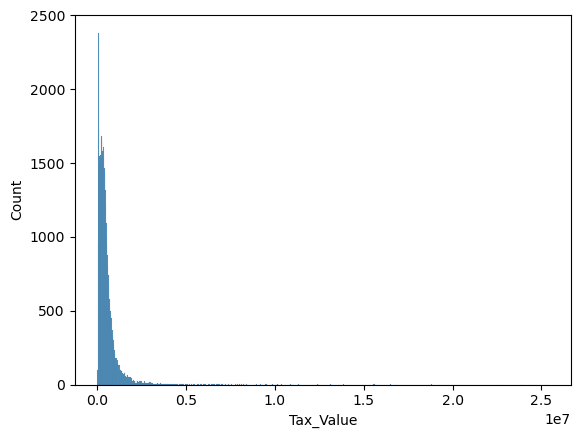

In [12]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Tax_Value)
plt.show()

In [13]:
# Tax_Value less than 2 million
df = df[df.Tax_Value <= 2000000]

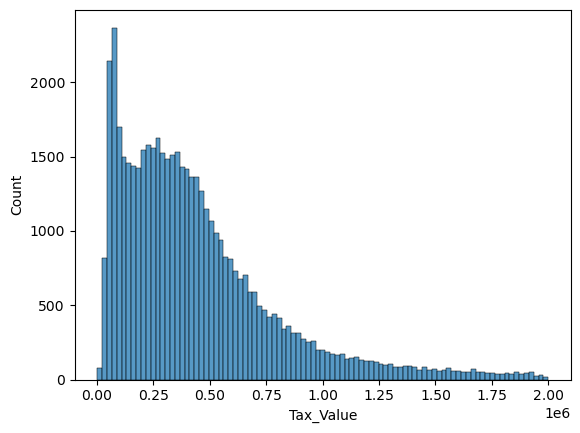

In [14]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Tax_Value)
plt.show()

#### Outliers in Sqft

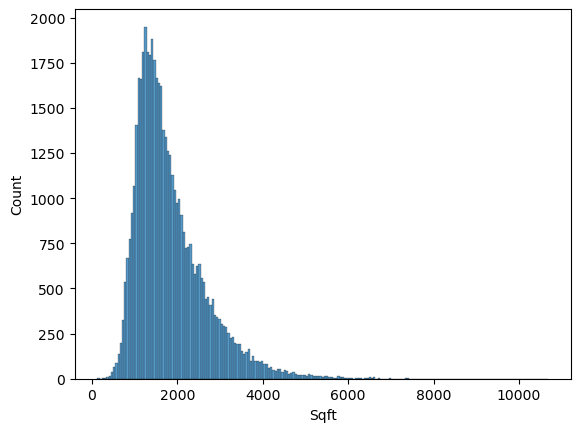

In [15]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Sqft)
plt.show()

In [16]:
# Sqft less than 6000 
df = df[df.Sqft <= 6000]

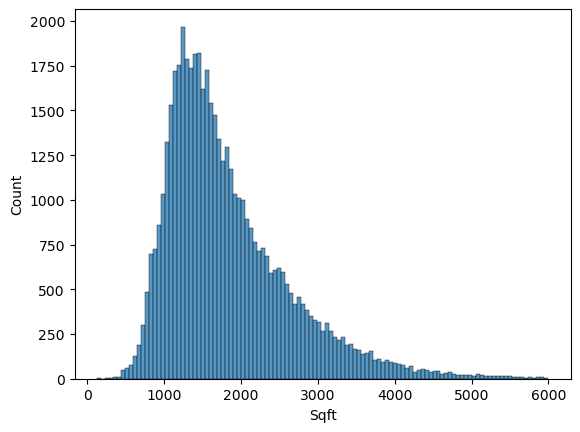

In [17]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Sqft)
plt.show()

#### Outliers in Bedrooms


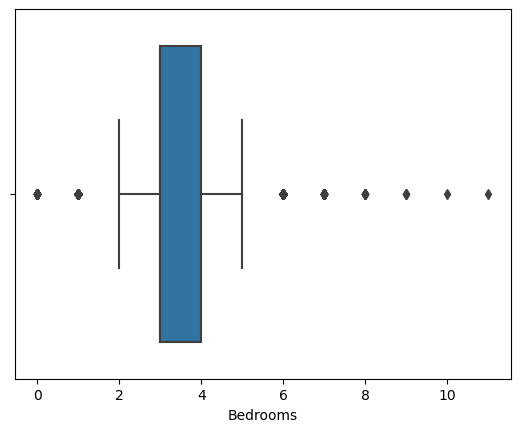

In [18]:
#Bedrooms before outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

In [19]:
# Bedrooms less than 8
df = df[df.Bedrooms <= 8]

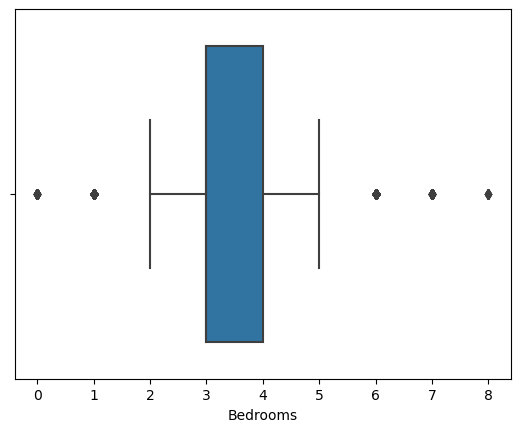

In [20]:
#Bedrooms after outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

#### Outliers in Bathrooms

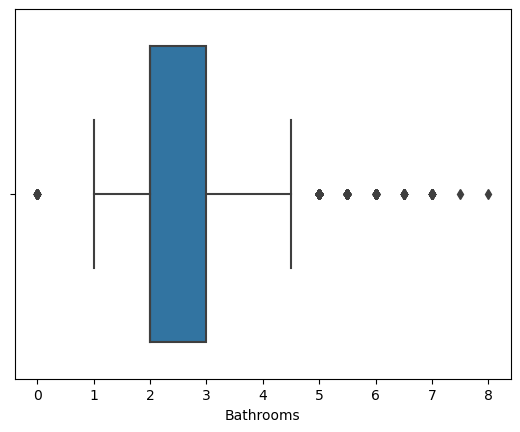

In [21]:
#Bathroom before outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

In [22]:
# Bathrooms less than 5
df = df[df.Bathrooms <= 5]

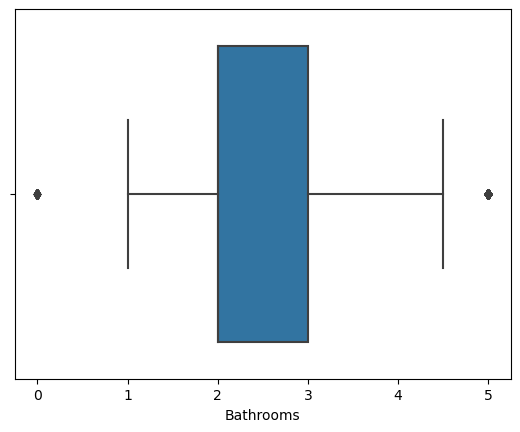

In [23]:
#Bathroom after outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

### Outliers in Lot_Size

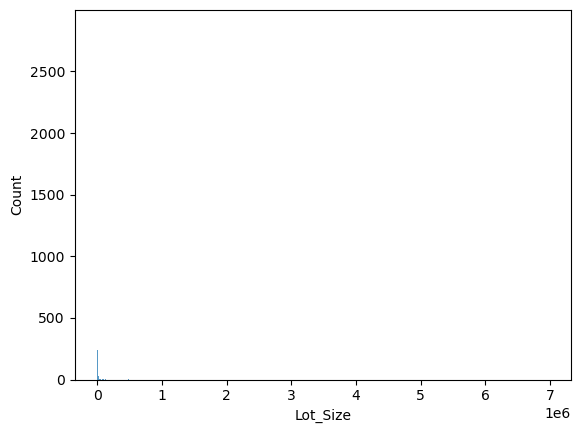

In [24]:
# Lot_Size histogram before outlier removal
sns.histplot(df.Lot_Size)
plt.show()

In [25]:
# Lot_Size greater than 12000
df = df[df.Lot_Size <= 20000]

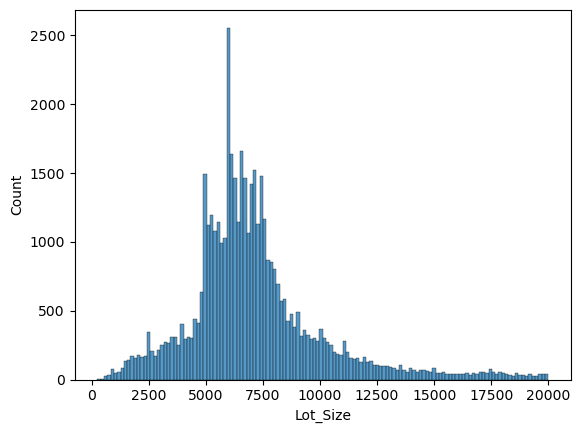

In [26]:
# Lot_Size histogram before outlier removal
sns.histplot(df.Lot_Size)
plt.show()

### Outliers in Year_Built

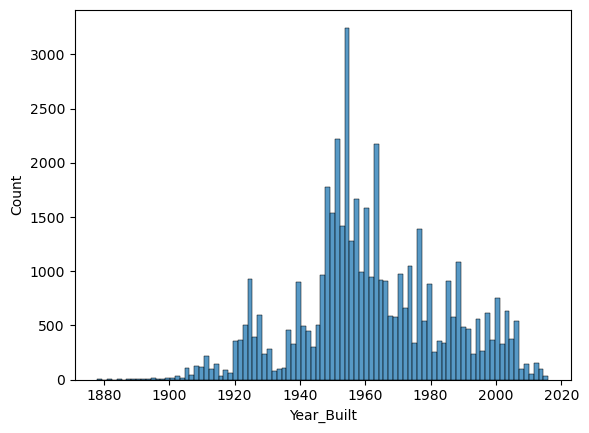

In [27]:
# Year_built histogram before outlier removal
sns.histplot(df.Year_Built)
plt.show()

In [28]:
# Year_Built greater than 1920
df = df[df.Year_Built >= 1920]

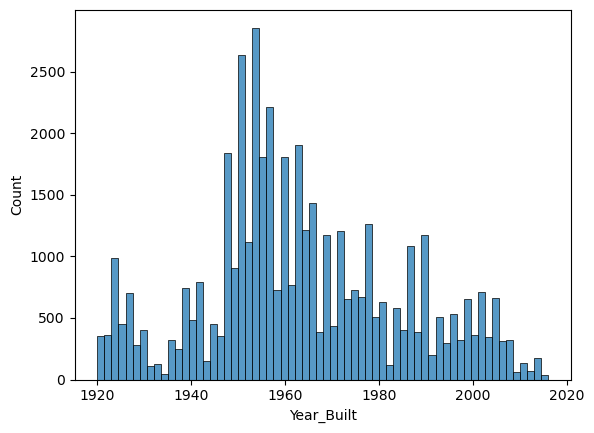

In [29]:
# Year_Built histogram after outlier removal
sns.histplot(df.Year_Built)
plt.show()

In [30]:
# After removal of outliers, there have been 6,685 houses removed. That is 13% of the data. 
df.shape

(45726, 13)

# Create Wrangle.py and test

In [31]:
# Call wrangle file with changes made from above from .py
df = w.wrangle_zillow2()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0,1,0,0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0,1,0,0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0,1,0,0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0,1,0,0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52432,510076.0,2302.0,LA,3.0,3.0,4425.0,1995.0,0.0,96282.0,12447.0,1,0,0
52433,70811.0,1598.0,LA,3.0,2.0,9553.0,1964.0,0.0,96337.0,37688.0,1,0,0
52434,336932.0,1696.0,LA,3.0,2.0,7615.0,1978.0,0.0,96282.0,12447.0,1,0,0
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0,1,0,0


## create train(60%), validate(20%) and test(20%) data set

In [32]:
## create train(60%), validate(20%) and test(20%) data set
train, validate, test = p.split_data(df)
train

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
15678,515074.0,1618.0,Orange,4.0,2.0,8500.0,1975.0,0.0,97063.0,33252.0,0,1,0
37721,858193.0,1881.0,Orange,3.0,2.5,1457.0,1964.0,0.0,96978.0,53571.0,0,1,0
22305,103394.0,1437.0,LA,4.0,2.0,8924.0,1955.0,0.0,96524.0,14542.0,1,0,0
36063,131261.0,2465.0,LA,4.0,3.0,7692.0,1966.0,0.0,96356.0,12447.0,1,0,0
1838,643884.0,1526.0,Orange,3.0,2.0,6025.0,1962.0,0.0,96967.0,25218.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41765,107447.0,2030.0,Orange,2.0,2.0,5200.0,1983.0,0.0,96954.0,52650.0,0,1,0
27898,88384.0,1370.0,LA,2.0,2.0,10849.0,1959.0,0.0,96496.0,6021.0,1,0,0
29550,403872.0,1289.0,LA,3.0,2.0,5507.0,1944.0,0.0,96021.0,272578.0,1,0,0
32698,282568.0,1362.0,LA,3.0,2.0,7494.0,1939.0,0.0,96514.0,33837.0,1,0,0


## Create scaled data set for modeling

In [33]:
# Create scaled data for modeling using MinMax scaler
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = p.scaled_df2(train, validate, test)
X_train_scaled

,Sqft,Bedrooms,Bathrooms,Year_Built,Pool
15678,0.258508,0.500,0.4,0.572917,0.0
37721,0.304885,0.375,0.5,0.458333,0.0
22305,0.226591,0.500,0.4,0.364583,0.0
36063,0.407865,0.500,0.6,0.479167,0.0
1838,0.242285,0.375,0.4,0.437500,0.0
...,...,...,...,...,...
41765,0.331159,0.250,0.4,0.656250,0.0
27898,0.214777,0.250,0.4,0.406250,0.0
29550,0.200494,0.375,0.4,0.250000,0.0
32698,0.213366,0.375,0.4,0.197917,0.0


# Explore

**Target = Tax_Value***
- Perform EDA on train data set only
    - How does Sqft affect Tax_Value?
    - How does Bedrooms affect Tax_Value?
    - How does Bathrooms affect Tax_Value?
    - How does Lot_Size affect Tax_Value?
    - How does Year_Built affect Tax_Value?
    - How does having a Pool affect Tax_Value?
    - Does location affect Tax_Value? Which location is the most expensive? The cheapest?
- Visualize relationships
- Confirm relationships with statistical testing
- Use Kbest and/or RFE (recursive feature elimination)

In [34]:
# look at train
train.head()

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
15678,515074.0,1618.0,Orange,4.0,2.0,8500.0,1975.0,0.0,97063.0,33252.0,0,1,0
37721,858193.0,1881.0,Orange,3.0,2.5,1457.0,1964.0,0.0,96978.0,53571.0,0,1,0
22305,103394.0,1437.0,LA,4.0,2.0,8924.0,1955.0,0.0,96524.0,14542.0,1,0,0
36063,131261.0,2465.0,LA,4.0,3.0,7692.0,1966.0,0.0,96356.0,12447.0,1,0,0
1838,643884.0,1526.0,Orange,3.0,2.0,6025.0,1962.0,0.0,96967.0,25218.0,0,1,0


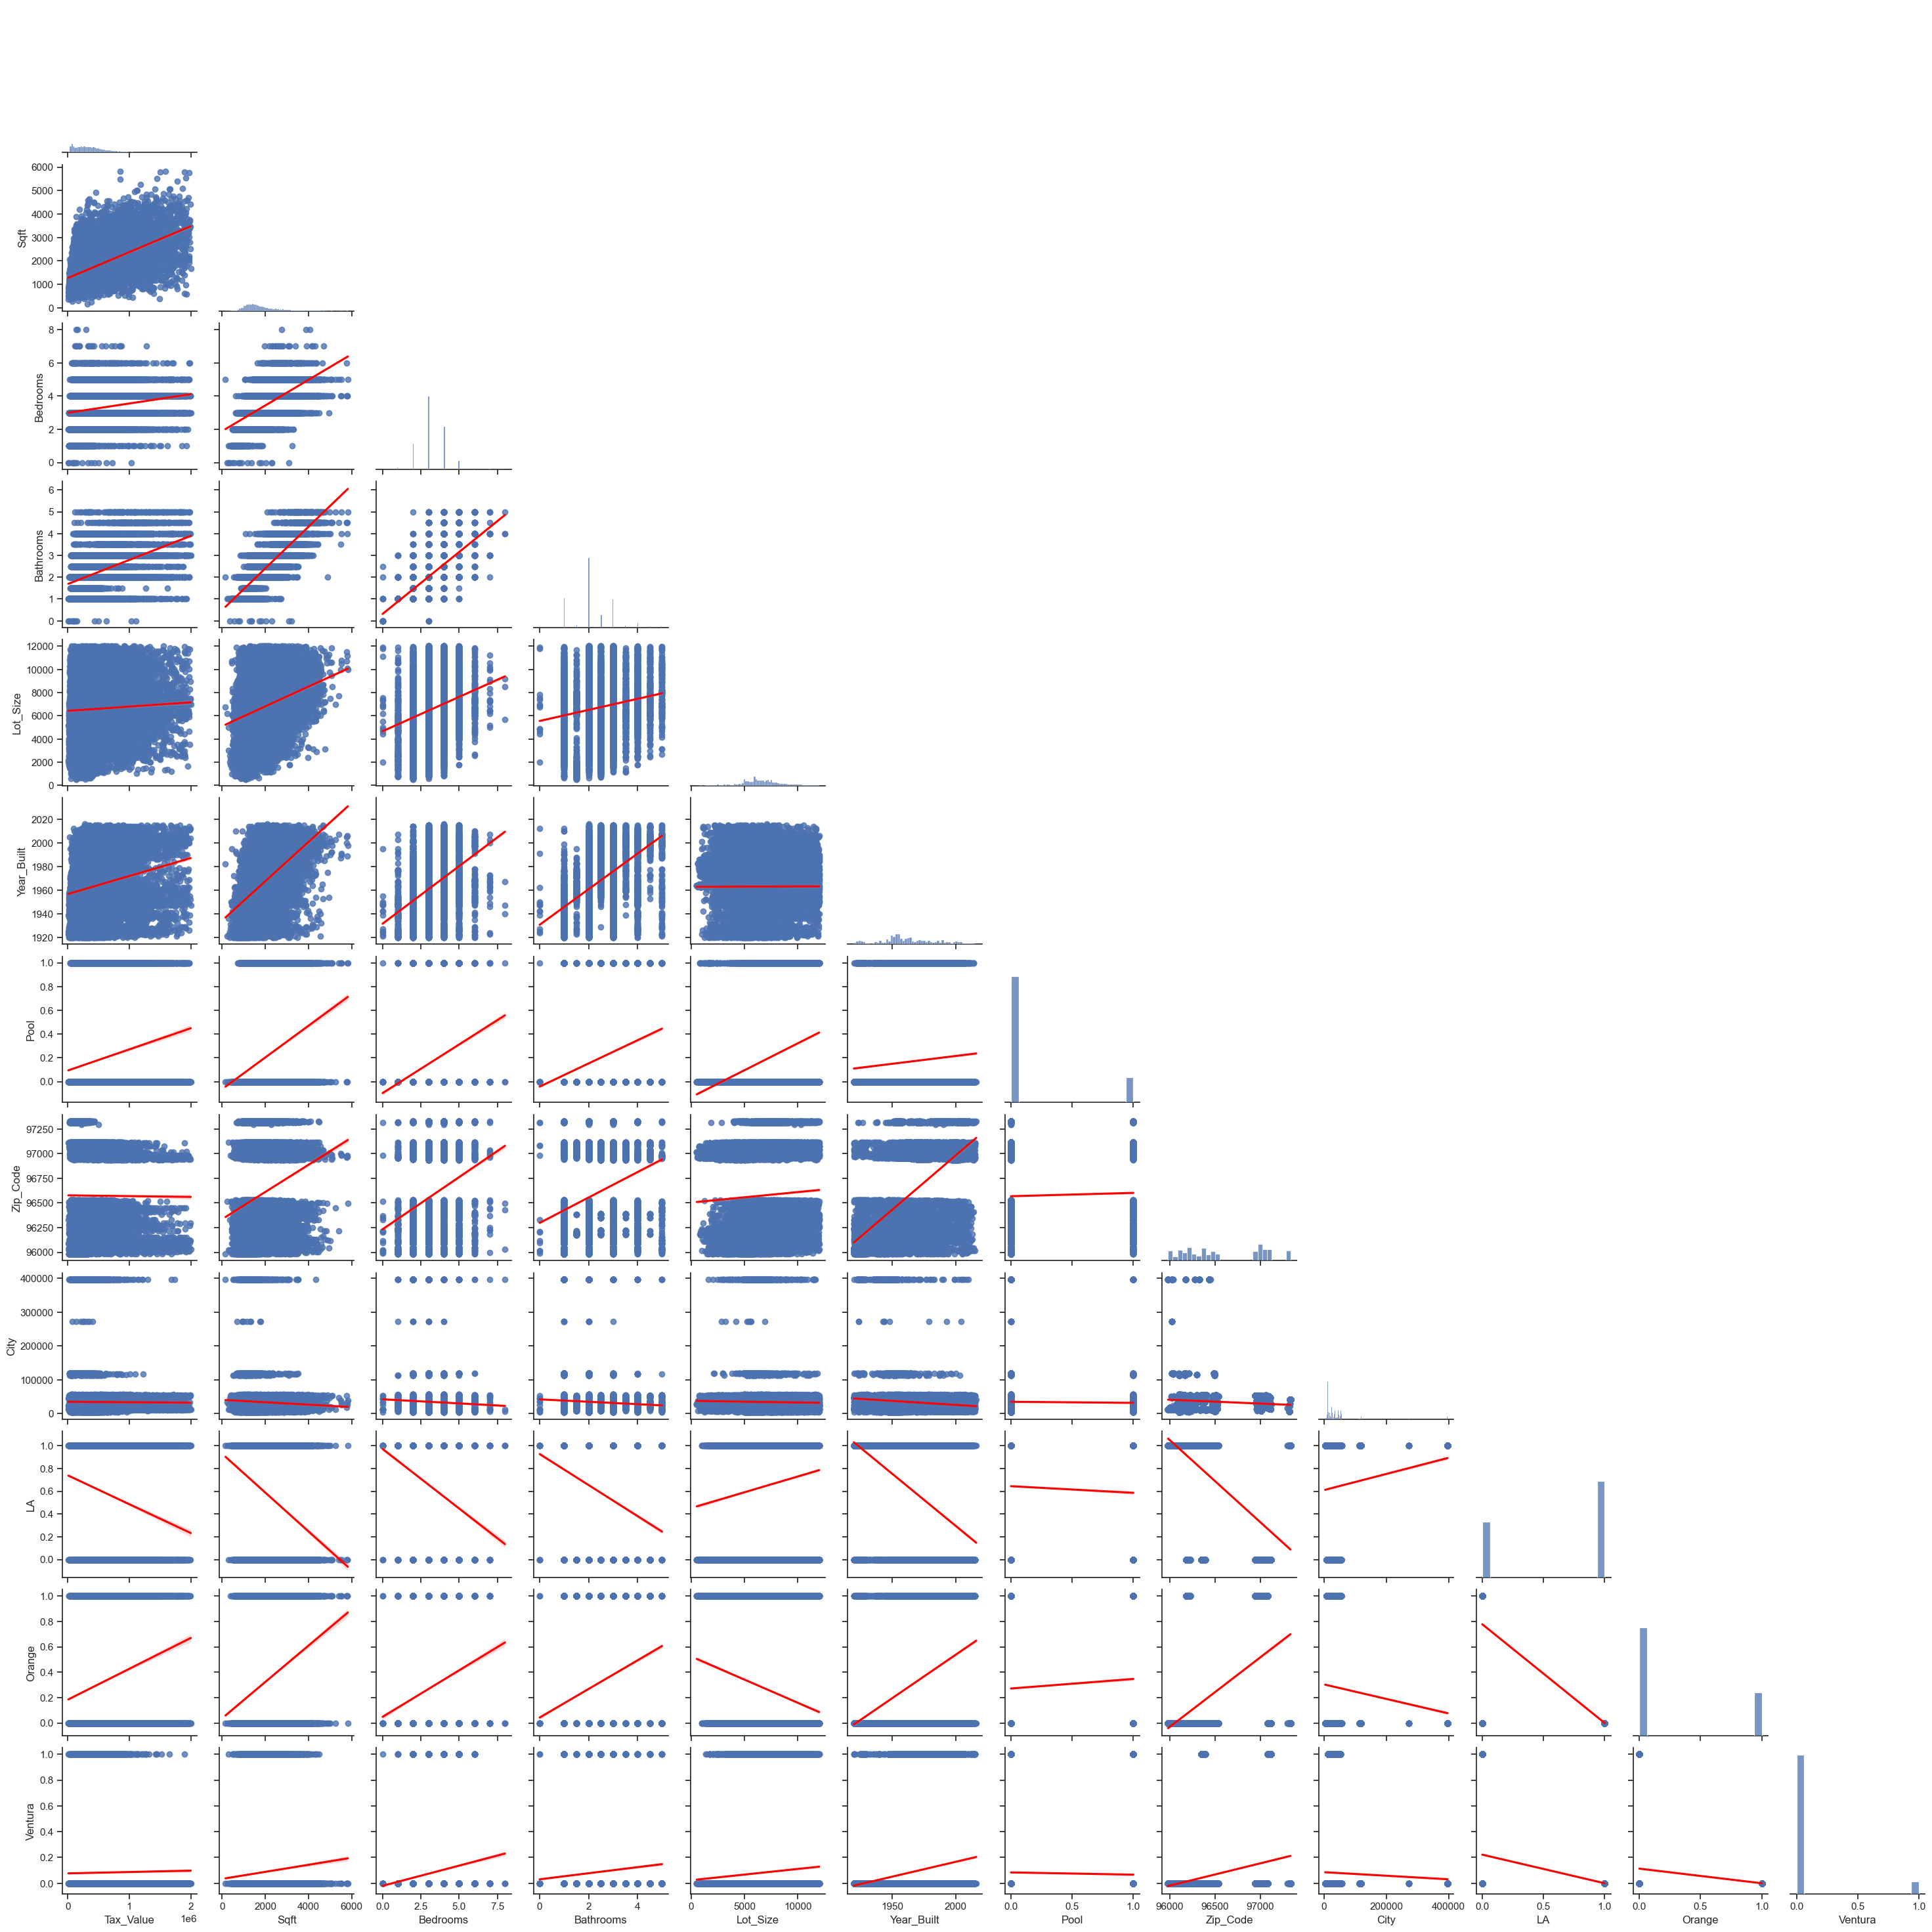

In [35]:
# Visualize pairwise relationships
e.plot_variable_pairs(train)

# Relationship between Sqft and Tax_Value
 $H_{0}$ Sqft does not influence price.
    
 $H_{a}$ Sqft does influence price.

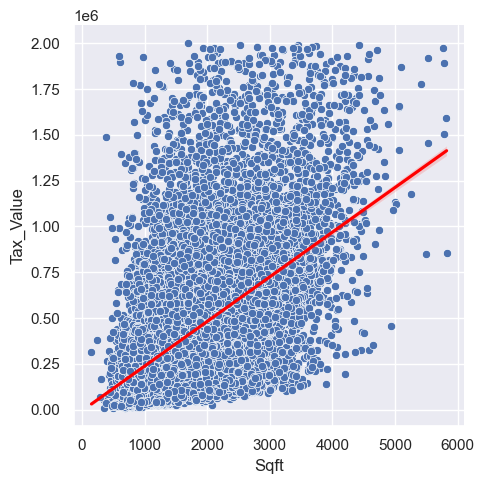

In [36]:
#Visualize Sqft and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Sqft", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Sqft", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm/or contradict Hypothesis statement

In [37]:
# run pearsonr test because they are both continuous variables with a normal distribution
r,p = pearsonr(train.Sqft, train.Tax_Value)
r,p

(0.519314080044076, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Sqft does affect Tax_Value

# Relationship between Lot_Size and Tax_Value
 $H_{0}$ Lot_Size does not influence price.
    
 $H_{a}$ Lot_Size does influence price.

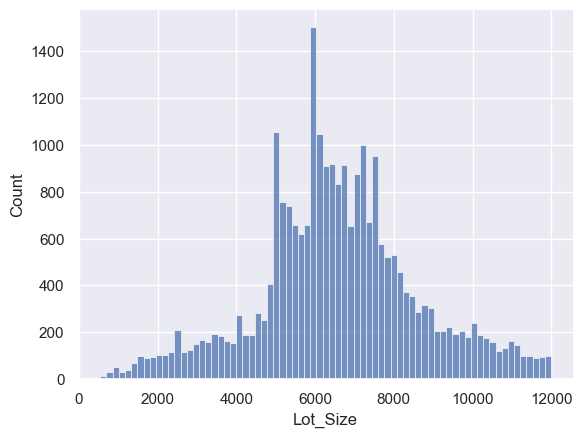

In [38]:
# Visualize lot size (normal distribution)
sns.histplot(train.Lot_Size)
plt.show()

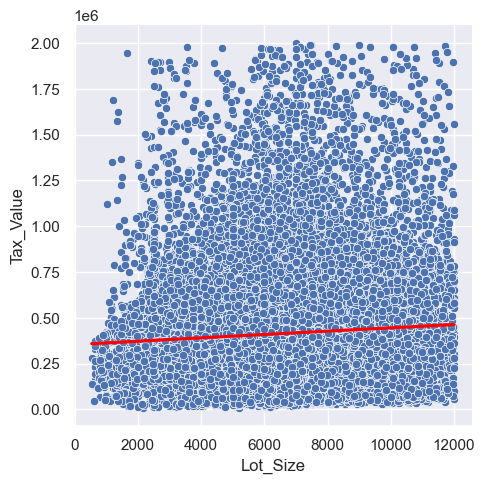

In [39]:
#Visualize Sqft and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Lot_Size", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Lot_Size", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm Hypothesis

In [133]:
r, p = pearsonr(train.Sqft, train.Tax_Value)
r,p

(0.519314080044076, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Lot_Size does affect Tax_Value

# Relationship between Tax_Value (continuous) and County (categorical)
 $H_{0}$ Location does not affect price.
    
 $H_{a}$ Location does affect price.

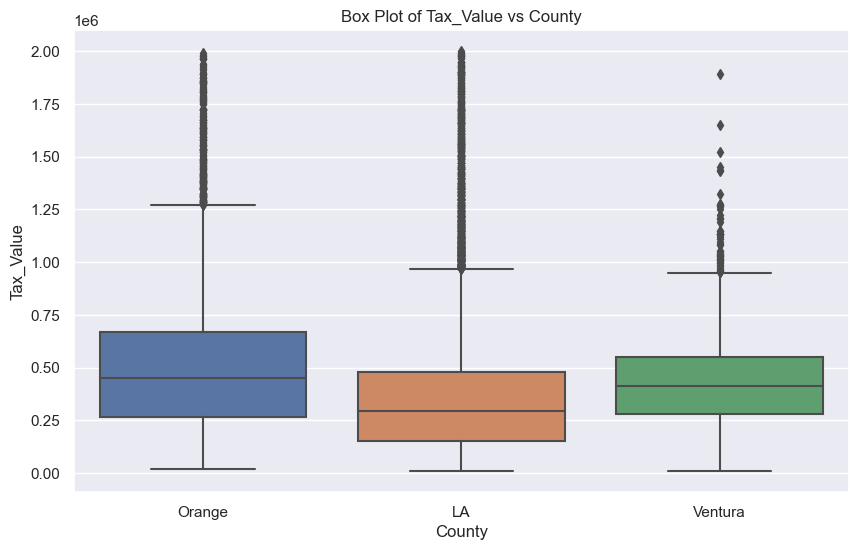

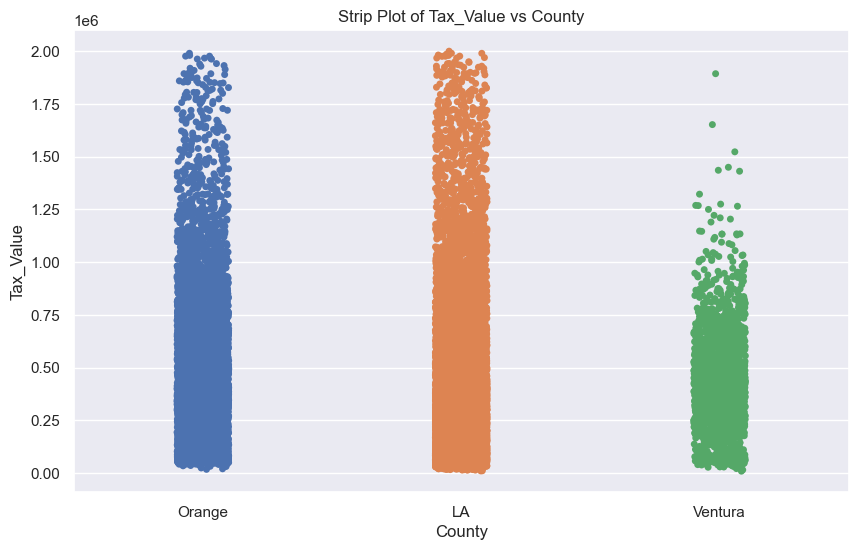

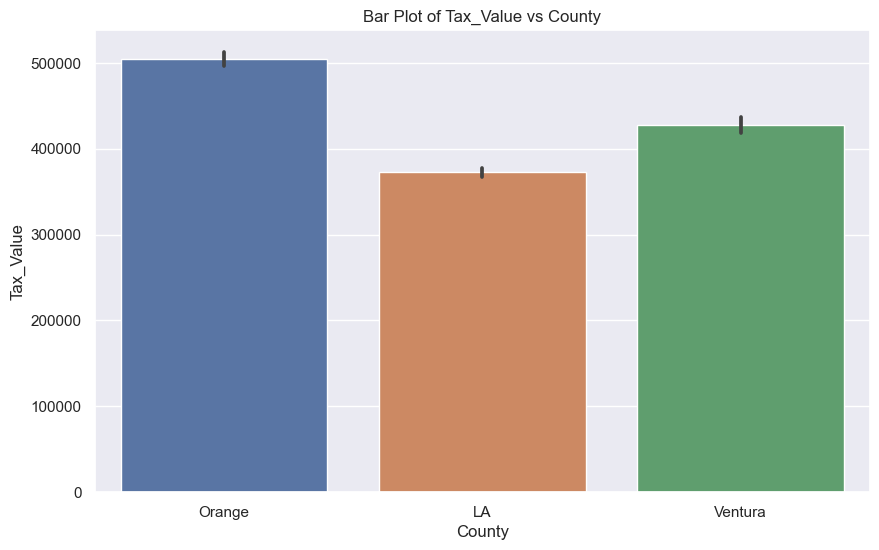

In [41]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'County', 'Tax_Value')

### prepare data for ANOVA stats test

In [42]:
# set three separate categories to Tax_Value and compare them
la = train[train.County == 'LA'].Tax_Value
orange = train[train.County == 'Orange'].Tax_Value
ventura = train[train.County == 'Ventura'].Tax_Value

# run the ANOVA test
tstat, pval = stats.f_oneway(la, orange, ventura)
tstat, pval

(429.2179566621505, 4.5653173045118134e-184)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that County location does affect Tax_Value

### Tax_Value (continuous) and Bedrooms (categorical)


 $H_{0}$ Number of Bedrooms does not affect price.
    
 $H_{a}$ Number of Bedrooms does affect price.

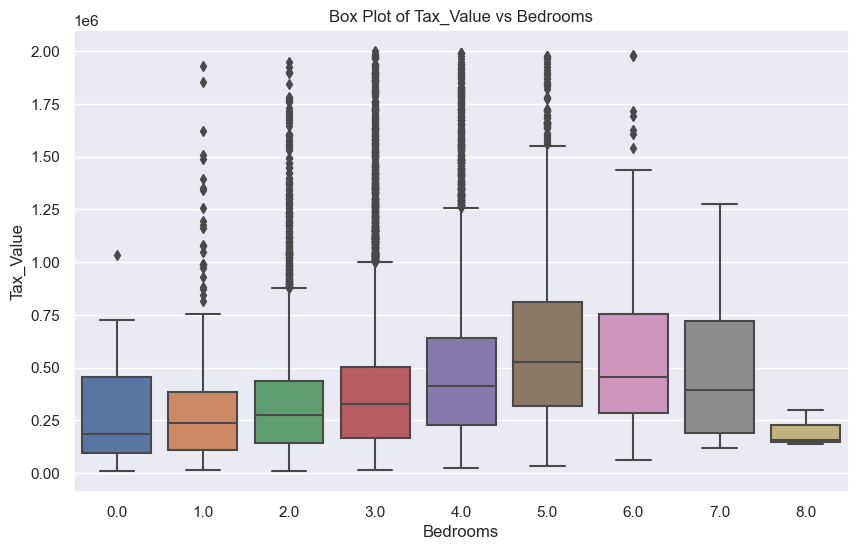

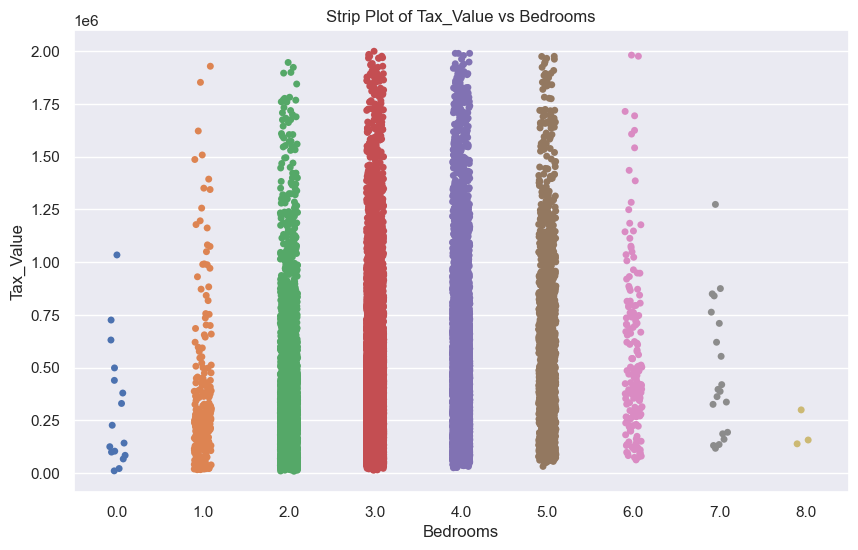

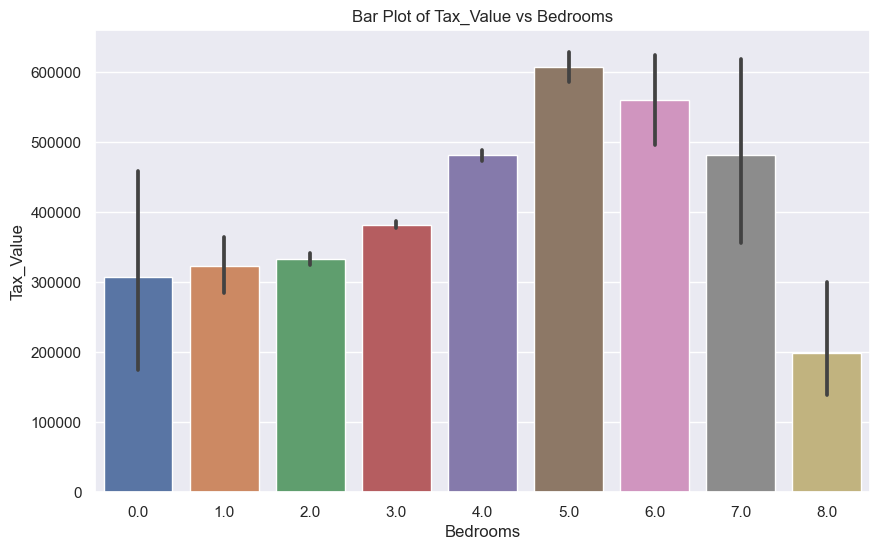

In [43]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Bedrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [44]:
# check if variances are equal
stats.levene(train.Bedrooms, train.Tax_Value)

LeveneResult(statistic=24821.93663590001, pvalue=0.0)

In [45]:
# run stats test
tstat, pval = stats.ttest_ind(train.Bedrooms, train.Tax_Value)
tstat, pval

(-204.41714822218282, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Bedrooms do affect Tax_Value

### Tax_Value (continuous) and Bathrooms (categorical)
 $H_{0}$ Number of Bathrooms does not affect price.
    
 $H_{a}$ Number of Bathrooms does affect price.

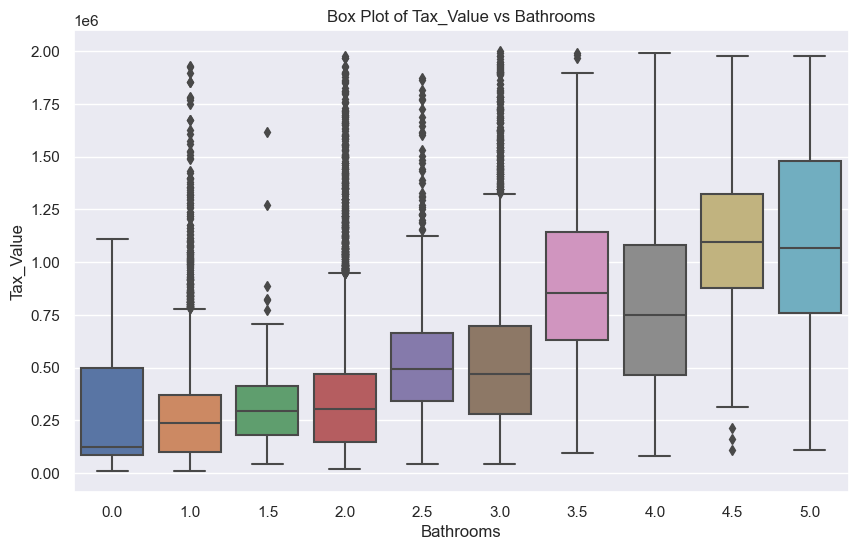

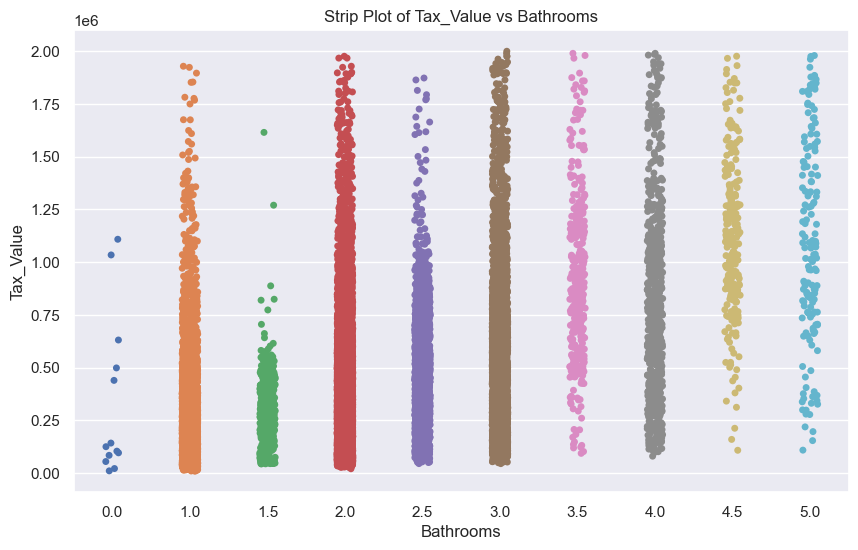

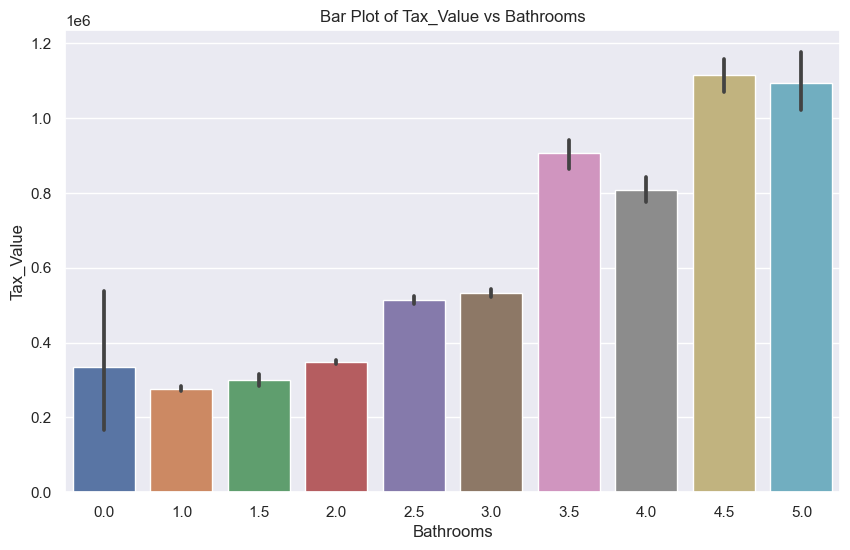

In [46]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Bathrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [47]:
# check if variances are equal
stats.levene(train.Bedrooms, train.Tax_Value)

LeveneResult(statistic=24821.93663590001, pvalue=0.0)

In [48]:
# run stats test
tstat, pval = stats.ttest_ind(train.Bathrooms, train.Tax_Value)
tstat, pval

(-204.4176815514808, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Bathroom do affect Tax_Value

### Tax_Value (continuous) and Pool (categorical)
 $H_{0}$ Having a pool does not affect price.
    
 $H_{a}$ Having a pool does affect price.

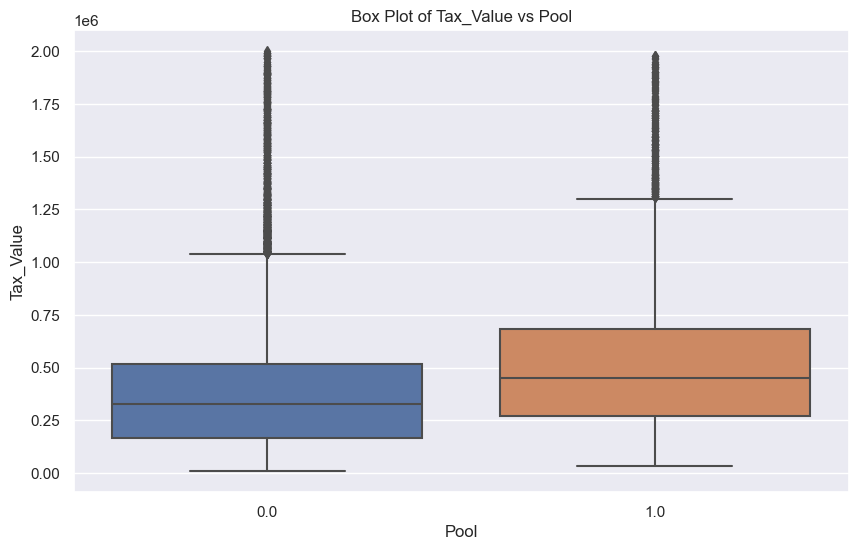

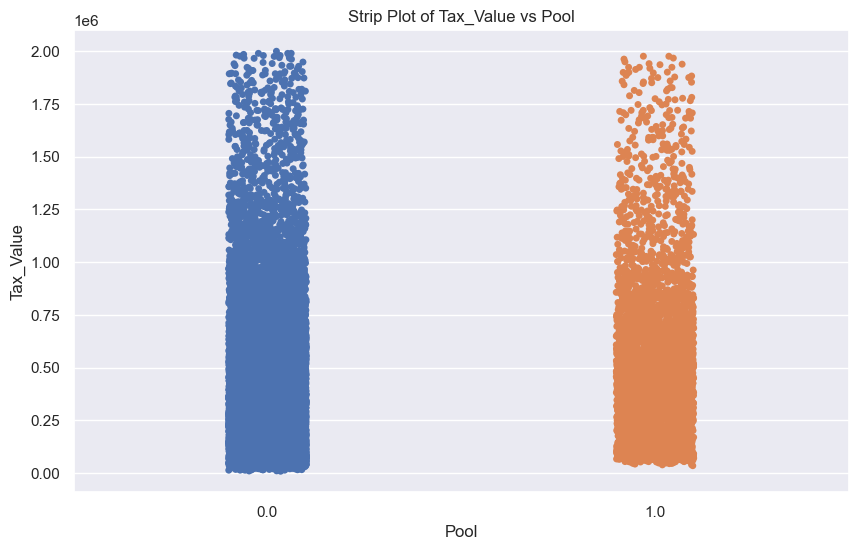

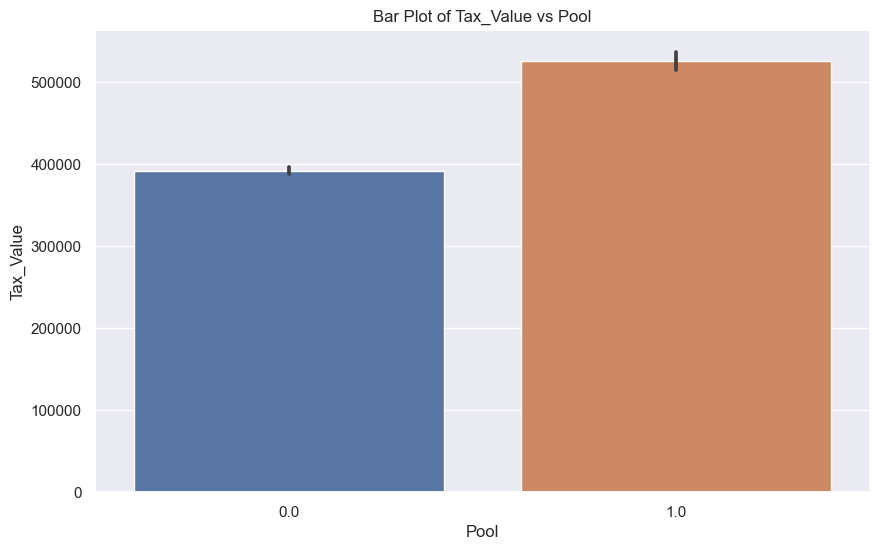

In [49]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Pool', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [50]:
# check for equal variance
stats.levene(train.Pool, train.Tax_Value)

LeveneResult(statistic=24822.030009284532, pvalue=0.0)

In [51]:
# run the stats test
tstat, pval = stats.ttest_ind(train.Pool, train.Tax_Value)
tstat, pval

(-204.41865629906528, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that have a Pool does affect Tax_Value

### Tax_Value (continuous) and Year_Built (continuous)
 $H_{0}$ Year_Built does not affect price.
    
 $H_{a}$ Year_Built does affect price.

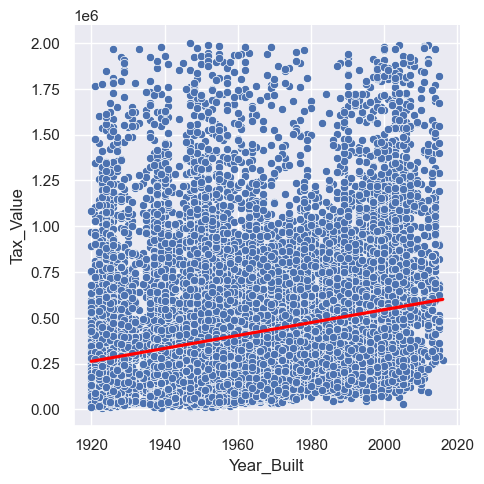

In [52]:
#Visualize Year_Built and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Year_Built", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Year_Built", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm Hypothesis

In [134]:
# run stats test
r, p = pearsonr(train.Sqft, train.Tax_Value)
r, p

(0.519314080044076, 0.0)

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that have a Year_Built does affect Tax_Value

In [54]:
Orange_df = train[train.County == 'Orange']

In [55]:
Orange_df_Bath1 = Orange_df[Orange_df.Bathrooms == 1]

In [56]:
Orange_df_Bath1.Tax_Value.mean()

344518.42176870746

In [57]:
Orange_df_Bath2 = Orange_df[Orange_df.Bathrooms == 2]

In [58]:
Orange_df_Bath2.Tax_Value.mean()

369744.41719389654

In [59]:
Orange_df_Bed1 = Orange_df[Orange_df.Bedrooms == 1]

In [60]:
Orange_df_Bed1.Tax_Value.mean()

469348.16363636364

In [61]:
Orange_df_Bed2 = Orange_df[Orange_df.Bedrooms == 2]

In [62]:
Orange_df_Bed2.Tax_Value.mean()

368311.2392156863

In [63]:
Orange_df_Bed3 = Orange_df[Orange_df.Bedrooms == 3]

In [64]:
Orange_df_Bed3.Tax_Value.mean()

455625.06323257246

In [65]:
Orange_df.Tax_Value.mean()

503988.99242319877

In [66]:
Orange_df.Year_Built.mean()

1973.983744317399

In [67]:
Orange_df.Pool.value_counts()

0.0    5779
1.0    1480
Name: Pool, dtype: int64

In [76]:
Ventura_df.Pool.value_counts()

0.0    1787
1.0     285
Name: Pool, dtype: int64

In [ ]:
LA_df.Pool.value_counts()

# Orange specific details
- Mean Tax value 503988
- Mean Bathrooms 2.4
- Mean Bedrooms 3.4
- Mean Year built 1974
- Mean Lot Size 6030
- Mean Sqft 1964
- 20% of homes have a pool

In [69]:
Ventura_df = train[train.County == 'Ventura']

In [70]:
Ventura_df.Tax_Value.mean()

427977.13416988414

In [71]:
Ventura_df.Year_Built.mean()

1975.9555984555984

In [72]:
Orange_df.Bathrooms.mean()

2.3993663038986086

In [73]:
Orange_df.Bedrooms.mean()

3.4147954263672684

In [74]:
Orange_df.Lot_Size.mean()

6030.455159112826

In [75]:
Orange_df.Sqft.mean()

1964.212150433944

# Ventura specific details
- Mean Tax value 427977
- Mean Bathrooms 2.3
- Mean Bedrooms 3.5
- Mean Year built 1976
- Mean Lot Size 7036
- Mean Sqft 1885
- 14% of homes have a pool

In [77]:
Ventura_df.Bathrooms.mean()

2.3308397683397684

In [78]:
Ventura_df.Bedrooms.mean()

3.509169884169884

In [79]:
Ventura_df.Lot_Size.mean()

7036.382722007722

In [80]:
Ventura_df.Sqft.mean()

1885.315637065637

# LA specific details
- Mean Tax value 372470
- Mean Bathrooms 2
- Mean Bedrooms 3
- Mean Year built 1956
- Mean Lot Size 6763
- Mean Sqft 1597
- 15% of homes have a pool

In [89]:
LA_df.Bathrooms.mean()

2.004014080158093

In [88]:
LA_df.Bedrooms.mean()

3.102142901253628

In [83]:
LA_df = train[train.County == 'LA']

In [84]:
LA_df.Tax_Value.mean()

372470.74482801213

In [85]:
LA_df.Year_Built.mean()

1956.4385845735812

In [86]:
LA_df.Lot_Size.mean()

6763.4552584450075

In [87]:
LA_df.Sqft.mean()

1597.229790650281

### Tax_Value (continuous) and Zip_Code (categorical)
 $H_{0}$ Zip_Code does not affect price.
    
 $H_{a}$ Zip_Code does affect price.

### Tax_Value (continuous) and City (categorical)
 $H_{0}$ Zip_Code does not affect price.
    
 $H_{a}$ Zip_Code does affect price.

 - Both Zip_Code and City have almost no correlation to Tax_Value, so we fail to reject the null hypothesis.

In [90]:
# Look at correlations
train.corr()

,Tax_Value,Sqft,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
Tax_Value,1.000000,0.519314,0.210759,0.444629,0.058104,0.231942,0.154539,-0.006127,-0.009755,-0.170478,0.174435,0.012480
Sqft,0.519314,1.000000,0.617942,0.817443,0.285078,0.537339,0.246480,0.225645,-0.047641,-0.243998,0.218648,0.069092
Bedrooms,0.210759,0.617942,1.000000,0.606693,0.246562,0.392998,0.188777,0.216037,-0.040524,-0.186736,0.139725,0.098483
Bathrooms,0.444629,0.817443,0.606693,1.000000,0.185847,0.568966,0.210342,0.246182,-0.055644,-0.227607,0.200950,0.069423
Lot_Size,0.058104,0.285078,0.246562,0.185847,1.000000,0.003112,0.251042,0.051932,-0.019403,0.118959,-0.167045,0.066161
Year_Built,0.231942,0.537339,0.392998,0.568966,0.003112,1.000000,0.075386,0.559715,-0.098401,-0.406565,0.324685,0.180602
Pool,0.154539,0.246480,0.188777,0.210342,0.251042,0.075386,1.000000,0.029997,-0.023996,-0.044965,0.062237,-0.023514
Zip_Code,-0.006127,0.225645,0.216037,0.246182,0.051932,0.559715,0.029997,1.000000,-0.092849,-0.632132,0.512907,0.267449
City,-0.009755,-0.047641,-0.040524,-0.055644,-0.019403,-0.098401,-0.023996,-0.092849,1.000000,0.075608,-0.065050,-0.025873
LA,-0.170478,-0.243998,-0.186736,-0.227607,0.118959,-0.406565,-0.044965,-0.632132,0.075608,1.000000,-0.830478,-0.391566


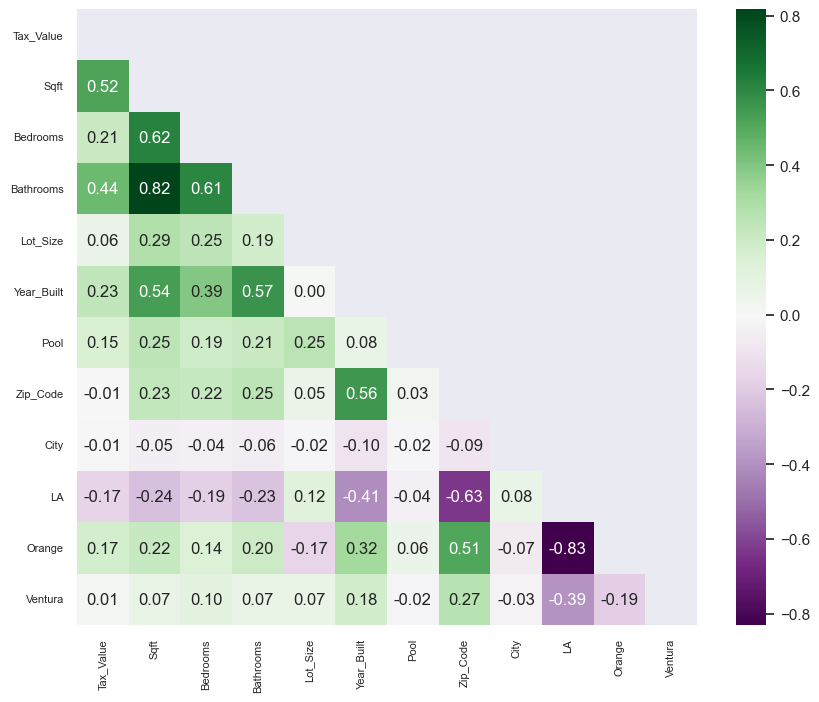

In [91]:

# Increase the figure size to accommodate the heatmap
plt.figure(figsize=(10, 8))

# Correlation heat map
sns.heatmap(train.corr(method='pearson'), cmap='PRGn', annot=True, fmt=".2f",
            mask=np.triu(train.corr(method='pearson')))

# Adjust the font size of the annotations
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Show the plot
plt.show()


# Exploration Takeaways

- All features are statistically significant to Tax_Value, based on pvalues gained through statistical testing
- This is a second run through, so I will remove all location independent variables. This decision is based on their low correlation to the target.
- Lot size is not correlated, therefore I will not move the variable into modeling. 
- Sqft, Bathrooms, Year_Built, Bedrooms, and Pool are the highest correlated independent variables to the target (Respectively).

# Modeling

### Set and explore the target (Tax_Value)

In [92]:
# set baseline
baseline = round(y_train.mean(),2)
baseline

414380.33

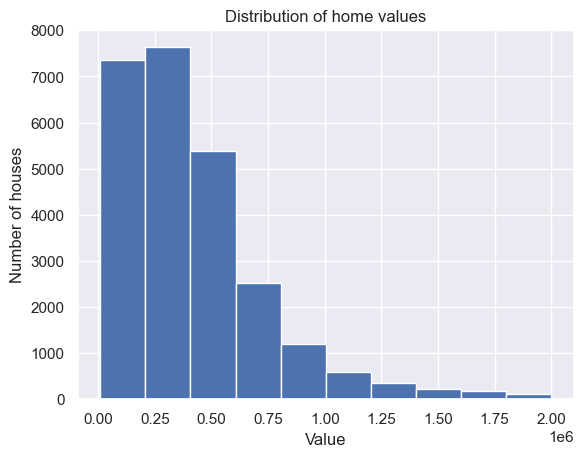

In [93]:
#visualize baseline
plt.hist(y_train)
plt.xlabel("Value")
plt.ylabel("Number of houses")
plt.title('Distribution of home values')
plt.show()

In [94]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([414380.33, 414380.33, 414380.33, ..., 414380.33, 414380.33,
       414380.33])

In [95]:
# Evaluate the baseline rmse and r2
rmse, r2 = eva.metrics_reg(y_train, baseline_array)
rmse, r2

(323850.28653725423, 2.220446049250313e-16)

In [96]:
# add results to a dataframe for comparison
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,323850.286537,2.220446e-16


# OLS - Ordinary Least Squares
# Multiple Regression
- also using Recursive Feature Eliminations

In [97]:
#### make it
OLS = LinearRegression()
#use Recursive Feature Eliminations
rfe = RFE(OLS, n_features_to_select=5)
#fit it
rfe.fit(X_train_scaled, y_train)
#use it on train
X_train_rfe = rfe.transform(X_train_scaled)
#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)

In [98]:
#see what the top features are regardless of location
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['Sqft' 'Bedrooms' 'Bathrooms' 'Year_Built' 'Pool']


In [99]:
#get array of rfe rankings and choose top minus location
rfe.ranking_

array([1, 1, 1, 1, 1])

In [100]:
# see whats in the rfe
X_train_rfe

array([[0.2585082 , 0.5       , 0.4       , 0.57291667, 0.        ],
       [0.3048845 , 0.375     , 0.5       , 0.45833333, 0.        ],
       [0.22659143, 0.5       , 0.4       , 0.36458333, 0.        ],
       ...,
       [0.20049374, 0.375     , 0.4       , 0.25      , 0.        ],
       [0.21336625, 0.375     , 0.4       , 0.19791667, 0.        ],
       [0.67677658, 0.625     , 0.9       , 0.86458333, 0.        ]])

In [101]:
#put results into a dataframe
pd.DataFrame(
{'rfe_ranking':rfe.ranking_},
index=X_train_scaled.columns)

,rfe_ranking
Sqft,1
Bedrooms,1
Bathrooms,1
Year_Built,1
Pool,1


In [102]:
# make a mask for the rfe
rfe.get_support()

array([ True,  True,  True,  True,  True])

In [103]:
#apply the mask to the transformed data
X_train_RFEtransformed = pd.DataFrame(
    rfe.transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[rfe.support_])
#see what is in it
X_train_RFEtransformed.head()

,Sqft,Bedrooms,Bathrooms,Year_Built,Pool
15678,0.258508,0.500,0.4,0.572917,0.0
37721,0.304885,0.375,0.5,0.458333,0.0
22305,0.226591,0.500,0.4,0.364583,0.0
36063,0.407865,0.500,0.6,0.479167,0.0
1838,0.242285,0.375,0.4,0.437500,0.0


### Build model

In [104]:
# build model for the top features
#fit the thing
OLS.fit(X_train_rfe, y_train)
#use the thing (make predictions)
pred_OLS = OLS.predict(X_train_rfe)
pred_val_OLS = OLS.predict(X_val_rfe)

### Evaluate

In [105]:
# Evaluate Train
eva.metrics_reg(y_train, pred_OLS)

(271205.4456227208, 0.2986928931276941)

In [106]:
# Evaluate Validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_OLS)
rmse, r2

(272662.80353766296, 0.29129447935980946)

In [107]:
#add to my metrics df
metrics_df.loc[1] = ['OLS', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,323850.286537,2.220446e-16
1,OLS,272662.803538,2.912945e-01


### Examine the model

In [108]:
# Get intercept
OLS.intercept_

161643.8827000933

In [109]:
# Get Coeficients
OLS.coef_

array([1468830.68365291, -593688.51458594,  300310.51163757,
       -108196.32561561,   26044.66720468])

In [110]:
# Print equation
print(f'Tax_Value = {OLS.intercept_:.3} + {OLS.coef_[0]:.2}*Sqft \
 {OLS.coef_[1]:.2}*Bedrooms + {OLS.coef_[2]:.2}*Bathrooms {OLS.coef_[3]:.2}*Year_Built +\
 {OLS.coef_[4]:.2}*Pool')

Tax_Value = 1.62e+05 + 1.5e+06*Sqft  -5.9e+05*Bedrooms + 3e+05*Bathrooms -1.1e+05*Year_Built + 2.6e+04*Pool


In [111]:
# Print explanation of equation
print(f'For every 1 point increase in Sqft, we predict a {OLS.coef_[0]:.2f} point increase in Tax_Value')
print(f'For every 1 point increase in Bedrooms, we predict a {OLS.coef_[1]:.2f} point decrease in Tax_Value')
print(f'For every 1 point increase in Bathrooms, we predict a {OLS.coef_[2]:.2f} point increase in Tax_Value')
print(f'For every 1 point increase in Year_Built, we predict a {OLS.coef_[3]:.2f} point decrease in Tax_Value')
print(f'For every 1 point increase in Pool, we predict a {OLS.coef_[4]:.2f} point increase in Tax_Value')


For every 1 point increase in Sqft, we predict a 1468830.68 point increase in Tax_Value
For every 1 point increase in Bedrooms, we predict a -593688.51 point decrease in Tax_Value
For every 1 point increase in Bathrooms, we predict a 300310.51 point increase in Tax_Value
For every 1 point increase in Year_Built, we predict a -108196.33 point decrease in Tax_Value
For every 1 point increase in Pool, we predict a 26044.67 point increase in Tax_Value


# LassoLars

In [112]:
#make it
lars = LassoLars(normalize=False, alpha=1)
#fit it
lars.fit(X_train_scaled, y_train)
#use it
pred_lars = lars.predict(X_train_scaled)
pred_val_lars = lars.predict(X_validate_scaled)

#### evaluate

In [113]:
#train
eva.metrics_reg(y_train, pred_lars)

(271205.4465736611, 0.29869288820964235)

In [114]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_lars)
rmse, r2

(272662.75262814877, 0.2912947440079382)

In [115]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,323850.286537,2.220446e-16
1,OLS,272662.803538,2.912945e-01
3,lars,272662.752628,2.912947e-01


# Polynomial Regression

In [116]:
# make the polynomial features to get a new set of features
# degree of 1 will be the same as our original data
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_val_degree3 = pf.transform(X_validate_scaled)

X_test_degree3 = pf.transform(X_test_scaled)

#### fit on a linear regression model

In [117]:
#make it
pr = LinearRegression()
#fit it
pr.fit(X_train_degree3, y_train)
#use it
pred_pr = pr.predict(X_train_degree3)
pred_val_pr = pr.predict(X_val_degree3)
pred_val_test=pr.predict(X_test_degree3)

#### evaluate

In [118]:
#train
eva.metrics_reg(y_train, pred_pr)

(266861.0237199552, 0.3209813166847161)

In [119]:
#validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_pr)
rmse, r2

(268230.4075798696, 0.31414857838501586)

In [120]:
#add to my metrics df
metrics_df.loc[4] = ['pr', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,323850.286537,2.220446e-16
1,OLS,272662.803538,2.912945e-01
3,lars,272662.752628,2.912947e-01
4,pr,268230.407580,3.141486e-01


# Generalized Linear Model (GLM)

In [121]:
#make it
glm = TweedieRegressor(power=1, alpha=0)
#fit it
glm.fit(X_train_scaled, y_train)
#use it
pred_glm = glm.predict(X_train_scaled)
pred_val_glm = glm.predict(X_validate_scaled)

#### evaluate

In [122]:
#train
eva.metrics_reg(y_train, pred_glm)

(272361.15487537876, 0.29270308676824774)

In [123]:
# validate
rmse, r2 = eva.metrics_reg(y_validate, pred_val_glm)
rmse, r2

(277390.2757157822, 0.2665061301325691)

In [124]:
#add to my metrics df
metrics_df.loc[5] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,323850.286537,2.220446e-16
1,OLS,272662.803538,2.912945e-01
3,lars,272662.752628,2.912947e-01
4,pr,268230.407580,3.141486e-01
5,glm,277390.275716,2.665061e-01


### Evaluate on Best Model

In [125]:
#use it
pred_test = pr.predict(X_test_degree3)

In [128]:
pr.intercept_

147691.6066692454

In [129]:
pr.coef_

array([ 3.53957654e-09,  4.92441913e+05, -4.76117275e+05,  3.90725931e+05,
        6.28668163e+05,  4.52083478e+04,  6.41450470e+05,  1.43171244e+06,
        2.36292553e+06, -1.40848294e+06,  5.56140448e+03,  2.90614134e+05,
       -5.10244724e+04, -6.69046833e+05, -2.04592420e+05, -1.76894958e+05,
       -2.23164028e+06,  5.68725338e+04, -2.86361501e+05, -6.66573231e+04,
        4.52083478e+04,  5.40805594e+05,  4.06317853e+06, -6.30927631e+06,
        1.45267272e+06, -6.28599387e+05, -7.32954761e+06,  3.27454706e+06,
       -1.93182727e+06,  3.07647813e+05,  4.97333397e+05,  3.18883384e+06,
       -4.24770395e+05, -7.85351029e+05,  1.19918241e+06,  5.56140448e+03,
        1.67531596e+06, -6.76139096e+05,  1.42822422e+06,  1.04012104e+05,
       -1.61190545e+06,  7.53706083e+05,  4.00496990e+05, -3.08423003e+05,
        1.63668870e+05, -2.04592420e+05,  6.88635531e+05, -7.69234519e+05,
        3.27283522e+05,  1.88694707e+06, -1.09695586e+06,  5.68725338e+04,
        2.11018414e+05,  

In [131]:
degree = 3  # Assuming the degree of the polynomial is 3
equation = f'y = {pr.coef_[0]} + {pr.coef_[1]} * x + {pr.coef_[2]} * x^2 + {pr.coef_[3]} * x^3'
equation

'y = 3.5395765445088323e-09 + 492441.91273172066 * x + -476117.27549626183 * x^2 + 390725.9314613782 * x^3'

In [132]:
import numpy as np

coefficients = np.array([3.53957654e-09, 4.92441913e+05, -4.76117275e+05, 3.90725931e+05,
                        6.28668163e+05, 4.52083478e+04, 6.41450470e+05, 1.43171244e+06,
                        2.36292553e+06, -1.40848294e+06, 5.56140448e+03, 2.90614134e+05,
                        -5.10244724e+04, -6.69046833e+05, -2.04592420e+05, -1.76894958e+05,
                        -2.23164028e+06, 5.68725338e+04, -2.86361501e+05, -6.66573231e+04,
                        4.52083478e+04, 5.40805594e+05, 4.06317853e+06, -6.30927631e+06,
                        1.45267272e+06, -6.28599387e+05, -7.32954761e+06, 3.27454706e+06,
                        -1.93182727e+06, 3.07647813e+05, 4.97333397e+05, 3.18883384e+06,
                        -4.24770395e+05, -7.85351029e+05, 1.19918241e+06, 5.56140448e+03,
                        1.67531596e+06, -6.76139096e+05, 1.42822422e+06, 1.04012104e+05,
                        -1.61190545e+06, 7.53706083e+05, 4.00496990e+05, -3.08423003e+05,
                        1.63668870e+05, -2.04592420e+05, 6.88635531e+05, -7.69234519e+05,
                        3.27283522e+05, 1.88694707e+06, -1.09695586e+06, 5.68725338e+04,
                        2.11018414e+05, 1.34400173e+05, -6.66573231e+04, 4.52083478e+04])

intercept = 147691.6066692454

degree = len(coefficients) - 1
equation = f'y = {intercept}'

for i in range(degree):
    equation += f' + {coefficients[i]} * x^{i + 1}'

print(equation)


y = 147691.6066692454 + 3.53957654e-09 * x^1 + 492441.913 * x^2 + -476117.275 * x^3 + 390725.931 * x^4 + 628668.163 * x^5 + 45208.3478 * x^6 + 641450.47 * x^7 + 1431712.44 * x^8 + 2362925.53 * x^9 + -1408482.94 * x^10 + 5561.40448 * x^11 + 290614.134 * x^12 + -51024.4724 * x^13 + -669046.833 * x^14 + -204592.42 * x^15 + -176894.958 * x^16 + -2231640.28 * x^17 + 56872.5338 * x^18 + -286361.501 * x^19 + -66657.3231 * x^20 + 45208.3478 * x^21 + 540805.594 * x^22 + 4063178.53 * x^23 + -6309276.31 * x^24 + 1452672.72 * x^25 + -628599.387 * x^26 + -7329547.61 * x^27 + 3274547.06 * x^28 + -1931827.27 * x^29 + 307647.813 * x^30 + 497333.397 * x^31 + 3188833.84 * x^32 + -424770.395 * x^33 + -785351.029 * x^34 + 1199182.41 * x^35 + 5561.40448 * x^36 + 1675315.96 * x^37 + -676139.096 * x^38 + 1428224.22 * x^39 + 104012.104 * x^40 + -1611905.45 * x^41 + 753706.083 * x^42 + 400496.99 * x^43 + -308423.003 * x^44 + 163668.87 * x^45 + -204592.42 * x^46 + 688635.531 * x^47 + -769234.519 * x^48 + 327283

In [126]:
#run metrics on pred_test data set
eva.metrics_reg(y_test, pred_test)

(270503.78432886495, 0.3008619449957164)

# Prepare for visualization

In [ ]:
#Add results to a data frame
plot_df = pd.DataFrame({'pred_OLS': pred_OLS,
                        'pred_lars': pred_lars,
                        'pred_pr': pred_pr,
                        'pred_glm': pred_glm,
                        'index': X_train_scaled.index})
plot_df

In [ ]:
# add y_train to a data frame
ploty_df = pd.DataFrame({'actual': y_train,
                        'index': y_train.index})
ploty_df

In [ ]:
# merge results and y_train on original index
merged_df = pd.merge(plot_df, ploty_df, on='index')
merged_df.set_index('index', inplace=True)
merged_df

In [ ]:
#rename merged df to dataframe for plotting
plot_this = merged_df
plot_this

# plot actuals vs predicted

In [ ]:
#Plotting actuals vs. predicted values
plt.scatter(plot_this.pred_pr, plot_this.actual, label='Polynomial 2nd degree', alpha=0.5, color='orange', s=10)


plt.plot(plot_this.actual, plot_this.actual, label='_nolegend_', color='purple', linestyle='--')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81), color='grey')

plt.title("Comparison of Predicted and Actual Values")
plt.ylabel("Actual Value")
plt.xlabel("Predicted Final Value")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5) 

plt.show()

#### plotting the residuals

In [ ]:
#Plotting of residuals
plt.axhline(0, ls=':', color='grey', label="No Error")

plt.scatter(plot_this.actual, plot_this.pred_OLS - plot_this.actual, alpha=0.5, color="red", s=10, label="Multiple Linear Regression")
plt.scatter(plot_this.actual, plot_this.pred_glm - plot_this.actual, alpha=0.5, color="yellow", s=10, label="TweedieRegressor")
plt.scatter(plot_this.actual, plot_this.pred_pr - plot_this.actual, alpha=0.5, color="blue", s=10, label="Polynomial 2nd degree")

plt.legend()
plt.title("Comparison of Residuals with Actual Values")
plt.xlabel("Actual Value")
plt.ylabel("Residual: Predicted Value - Actual value")

plt.tight_layout()

plt.show()

#### histogram of actual and predicted values

In [ ]:
#histogram of actual and predicted values
plt.hist(plot_this.actual, bins=30, color='blue', alpha=0.7, label="Actual")
plt.hist(plot_this.pred_OLS, bins=30, color='red', alpha=0.7, label="Linear Regression")
plt.hist(plot_this.pred_glm, bins=30, color='yellow', alpha=0.7, label="Tweedie Regressor")
plt.hist(plot_this.pred_pr, bins=30, color='green', alpha=0.7, label="Polynomial 2nd degree")

plt.xlabel("Value")
plt.ylabel("Number of Houses")
plt.title("Comparison of Distribution: Actual vs Predicted Values")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines

plt.show()


# Modeling Takeaways
- best performing model was Polynomial Regression
- the R^2 value is .31 and has the lowest RMSE of the 4 models that were ran 269996.35 
- I ran many iterations of the data, and found that this is the best predictive model. It does perform better than the baseline of 433274.67. 
- I recommend better data collecting, to avoid massive amounts of null values in various categories (garage, story)
- There has to be a better way to identify Zip Codes, City and other location metrics. With more time I would like to further delineate location between the three counties. Lastly, I would programmatically handle outliers based on standard deviation or quartiles.

In [ ]:
#scatter plot of actual vs. predicted model
plt.scatter(plot_this.pred_pr, plot_this.actual, label='Polynomial 2nd degree', alpha=0.5, color='orange', s=10)
plt.scatter(plot_this.actual, plot_this.actual, label='Actual Values', alpha=0.5, color='blue', s=10)

plt.plot(plot_this.actual, plot_this.actual, label='_nolegend_', color='grey', linestyle='--')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81), color='grey')

plt.title("Comparison of Predicted and Actual Values")
plt.ylabel("Actual Value")
plt.xlabel("Predicted Final Value")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5) 

plt.show()

In [ ]:
#Plot residuals of final model
plt.axhline(0, ls=':', color='grey', label="No Error")

plt.scatter(plot_this.actual, plot_this.pred_pr - plot_this.actual, alpha=0.5, color="blue", s=10, label="Polynomial 2nd degree")

plt.legend()
plt.title("Comparison of Residuals with Actual Values")
plt.xlabel("Actual Value")
plt.ylabel("Residual: Predicted Value - Actual value")

plt.tight_layout()

plt.show()

In [ ]:
#Histogram of actual and predicted model
plt.hist(plot_this.pred_pr, bins=30, color='green', alpha=0.7, label="Polynomial 2nd degree")
plt.hist(plot_this.actual, bins=30, color='purple', alpha=0.4, label="Actual Values")
plt.xlabel("Value")
plt.ylabel("Number of Houses")
plt.title("Comparison of Distribution: Actual vs Predicted Values")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines

plt.show()